In [1]:
# import all that's needed
import sys
sys.path.insert(0,'/home/aobulj/data/Hi-Fi_mocks')
sys.path.insert(0,'/home/aobulj/git/Pylians3/library')
from lib.tng_lib import *
import numpy as np
from nbodykit.lab import *
import time
from argparse import ArgumentParser
from scipy import interpolate
start = time.time()
import h5py
import readfof

comm = CurrentMPIComm.get()    
print ('comm', comm, 'comm.rank', comm.rank, 'comm.size', comm.size)
rank = comm.rank

sim = 0

seed = 5 + sim
Nmesh = 128
BoxSize = 1000.
zout = 1.
output_folder = './output_folder_rsd/'

if zout == 3:
    snapnum = 0 
elif zout==2:
    snapnum = 1
elif zout==1:
    snapnum = 2
elif zout==0.5:
    snapnum = 3
elif zout==0:
    snapnum = 4

##########################
# ## General parameters ###
# #########################

zic  = 127 # TNG initial redshift
kmin = np.pi/BoxSize # kmin used in Pk measurements [h/Mpc]
axis = 2 # coordinate axis along which RSDs have been applied; matching z-axis, los=[0,0,1]
Nmufid = 6 # number of mu bins for nbodykit FFTPower, this is actually 2x the number of (positive) mu bins

print ("Generating HI mock in redshift-space at output redshift z=%.1f, in a BoxSize L=%.1f on a Nmesh=%i^3 grid with IC seed %i..."\
       %(zout, BoxSize, Nmesh, seed))

# Quijote cosmology:
c = cosmology.Cosmology(h=0.6711, Omega0_b=0.049, Omega0_cdm=0.3175 - 0.049, n_s=0.9624, m_ncdm=[]).match(sigma8=0.834)
Plin_zout = cosmology.LinearPower(c, zout)
Plin_z0 = cosmology.LinearPower(c, 0)
Dic  = c.scale_independent_growth_factor(zic)
Dout = c.scale_independent_growth_factor(zout)
fout = c.scale_independent_growth_rate(zout)

# Parameter paths/options for saving/plotting
# params_path = "./data/r_space_bestfit_params/"
save_outputs = True
plot = True
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#################
### Main part ###
#################

# Generate linear overdensity field at zic
print ('Generating initial density field... ')
dlin = get_dlin(seed, Nmesh, BoxSize, Plin_z0, comm)
dlin *= Dic
print ('done (elapsed time: %1.f sec.)'%(time.time()-start))

# Compute shifted fields
print ('Computing shifted fields... ')
dz, d1, d2, dG2, dG2par, d3 = generate_fields_rsd_new(dlin, c, zic, zout, comm=comm)
p1 = FFTPower(d1, mode='2d', kmin=kmin, Nmu=Nmufid, poles=[0,2])
print ('done (elapsed time: %1.f sec.)'%(time.time()-start))

# Orthogonalize shifted fields
print ('Orthogonalizing shifted fields... ')
d2, dG2, d3 = orthogonalize_rsd(d1, d2, dG2, d3, Nmufid)
# d2, dG2, d3 = orthogonalize_rsd_loc(d1, d2, dG2, d3, Nmu=Nmufid, kmin=kmin)
print ('done (elapsed time: %1.f sec.)'%(time.time()-start))

comm <mpi4py.MPI.Intracomm object at 0x14a7dc235830> comm.rank 0 comm.size 1
Generating HI mock in redshift-space at output redshift z=1.0, in a BoxSize L=1000.0 on a Nmesh=128^3 grid with IC seed 5...
Generating initial density field... 
done (elapsed time: 6 sec.)
Computing shifted fields... 
done (elapsed time: 15 sec.)
Orthogonalizing shifted fields... 
done (elapsed time: 16 sec.)


log 10 Mh_bins =  [12.5 12.8]


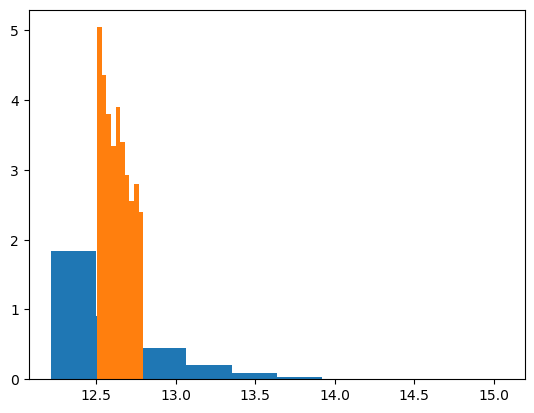

cat.mean 1.9208528101444244e-08
(633988, 3) (633988, 3)
(633988, 3) 2 -15.5833025 1012.23096
0.0015869141 999.9997
catrsd.mean 2.4330802261829376e-08


Text(0, 0.5, '$z\\,[h^{-1}\\,\\mathrm{Mpc}]$')

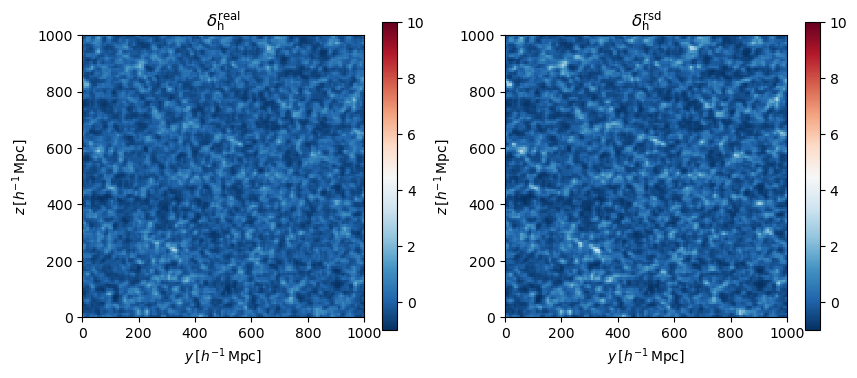

In [39]:
#################
### Load data ###
#################

Mh_bins = np.array([10**12.5, 10**12.8])#, 10**13.8, 10**15.2])
    
snapdir = '/home/aobulj/data/TNG_fields/Quijote/HR/%i'%sim
    
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                      swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
pos_h = FoF.GroupPos/1e3            #Halo positions in Mpc/h
mass  = FoF.GroupMass*1e10          #Halo masses in Msun/h
vel_h = FoF.GroupVel*(1.0+zout) #km/s

print ('log 10 Mh_bins = ', np.log10(Mh_bins))
valid = (mass>Mh_bins[0]) & (mass<Mh_bins[1])
pos_h, vel_h = pos_h[valid], vel_h[valid]

plt.hist(np.log10(mass), density=True)
plt.hist(np.log10(mass[valid]), density=True)
plt.show()

nbar = valid[valid].size/BoxSize**3    
dtype = np.dtype([('Position', ('f8', 3)),])

cat = np.empty((pos_h.shape[0],), dtype=dtype)
cat['Position'] = pos_h
cat = ArrayCatalog(cat, BoxSize=BoxSize * np.ones(3), Nmesh=Nmesh)
cat = cat.to_mesh(compensated=True).paint() - 1.0
print('cat.mean', cat.cmean())

print (pos_h.shape, vel_h.shape)
# pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

def rsd_pos(pos, vel, BoxSize, c, redshift, axis):
    factor = (1+redshift) / (100 * c.efunc(redshift))

    pos[:,axis] = pos[:,axis] + vel[:,axis] * factor
    print (pos.shape, axis, pos[:,axis].min(), pos[:,axis].max())
    pos[:,axis] %= BoxSize
    print (pos[:,axis].min(), pos[:,axis].max())
    return pos
    
pos_h_rsd = rsd_pos(pos_h, vel_h, BoxSize, c, zout, axis)

catrsd = np.empty((pos_h_rsd.shape[0],), dtype=dtype)
catrsd['Position'] = pos_h_rsd
catrsd = ArrayCatalog(catrsd, BoxSize=BoxSize * np.ones(3), Nmesh=Nmesh)
catrsd = catrsd.to_mesh(compensated=True).paint() - 1.0
print('catrsd.mean', catrsd.cmean())

preal = FFTPower(cat, mode='1d', kmin=kmin)
prsd  = FFTPower(catrsd, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)

nslice = 25
Rg = 5
titles = np.array(['HI truth', 'HI bestfit', 'diff'])
imshow_kw = dict(interpolation='none', cmap='RdBu_r', vmin=-1, vmax=10, extent=(0,BoxSize,0,BoxSize), origin='lower')
plt.figure(figsize=(10,4))
plt.subplot(121)
cax = plt.imshow(ArrayMesh(cat, BoxSize).apply(Gaussian(Rg)).paint()[:int(nslice*Nmesh/256),:,:].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{h}^\\mathrm{real}$')
plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.subplot(122)
cax = plt.imshow(ArrayMesh(catrsd, BoxSize).apply(Gaussian(Rg)).paint()[:int(nslice*Nmesh/256),:,:].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{h}^\\mathrm{rsd}$')
plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")

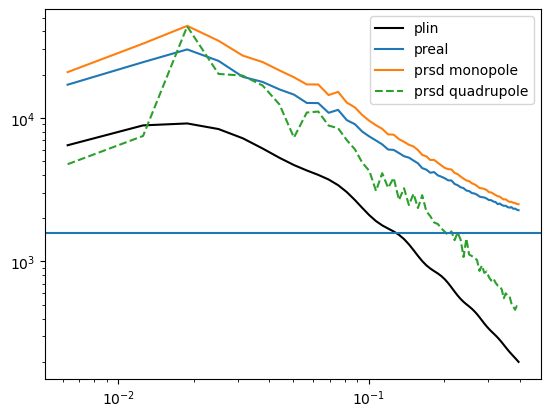

In [40]:
plt.loglog(preal.power.coords['k'], Plin_zout(preal.power.coords['k']), 'k', label = 'plin')
plt.loglog(preal.power.coords['k'], preal.power['power'].real, label = 'preal')
plt.loglog(prsd.power.coords['k'], prsd.poles['power_0'].real, label = 'prsd monopole')
plt.loglog(prsd.power.coords['k'], prsd.poles['power_2'].real, '--', label = 'prsd quadrupole')
plt.axhline(1/nbar)
plt.legend()

In [41]:
print (valid[valid].size)

633988


In [42]:
catrsd = ArrayMesh(catrsd, BoxSize)

pz = FFTPower(dz, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
kk = pz.power.coords['k']
Nmu0 = int(pz.attrs['Nmu']/2)
mus = pz.power.coords['mu'][Nmu0:]
pz.power = pz.power[:,Nmu0:]

# p1     = FFTPower(d1, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pd1ort = FFTPower(d1, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pd2ort = FFTPower(d2, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pG2ort = FFTPower(dG2,mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pd3ort = FFTPower(d3, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)

rsd_minus_ck = (catrsd.to_field(mode='complex') - (dz-3./7.*fout*dG2par)).c2r()

pHI1ort = FFTPower(rsd_minus_ck, mode='2d', second=d1, kmin=kmin, poles=[0,2], Nmu=Nmufid)
pHI2ort = FFTPower(rsd_minus_ck, mode='2d', second=d2, kmin=kmin, poles=[0,2], Nmu=Nmufid)
pHIG2ort= FFTPower(rsd_minus_ck, mode='2d', second=dG2,kmin=kmin, poles=[0,2], Nmu=Nmufid)
pHI3ort = FFTPower(rsd_minus_ck, mode='2d', second=d3, kmin=kmin, poles=[0,2], Nmu=Nmufid)

beta1 = pHI1ort.power['power'].real[:,Nmu0:]/pd1ort.power['power'].real[:,Nmu0:]
beta2 = pHI2ort.power['power'].real[:,Nmu0:]/pd2ort.power['power'].real[:,Nmu0:]
betaG2 = pHIG2ort.power['power'].real[:,Nmu0:]/pG2ort.power['power'].real[:,Nmu0:]
beta3 = pHI3ort.power['power'].real[:,Nmu0:]/pd3ort.power['power'].real[:,Nmu0:]

beta1_interkmu = interp1d_manual_k_binning(pz.power['k'], beta1, fill_value=[beta1[0][0],beta1[-1][0]], Ngrid=pz.attrs['Nmesh'], L = pz.attrs['BoxSize'][0], Pkref=prsd, kind='manual_Pk_k_mu_bins')
beta2_interkmu = interp1d_manual_k_binning(pz.power['k'], beta2, fill_value=[beta2[0][0],beta2[-1][0]], Ngrid=pz.attrs['Nmesh'], L = pz.attrs['BoxSize'][0], Pkref=prsd, kind='manual_Pk_k_mu_bins')
betaG2_interkmu = interp1d_manual_k_binning(pz.power['k'], betaG2, fill_value=[betaG2[0][0],betaG2[-1][0]], Ngrid=pz.attrs['Nmesh'], L = pz.attrs['BoxSize'][0], Pkref=prsd, kind='manual_Pk_k_mu_bins')
beta3_interkmu = interp1d_manual_k_binning(pz.power['k'], beta3, fill_value=[beta3[0][0],beta3[-1][0]], Ngrid=pz.attrs['Nmesh'], L = pz.attrs['BoxSize'][0], Pkref=prsd, kind='manual_Pk_k_mu_bins')

In [43]:
beta1.shape

(63, 3)

Text(0.5, 0.98, 'Quijote, $z=1.0$, $10^{12.50}<M_h[M_\\odot/h]<10^{12.80}$')

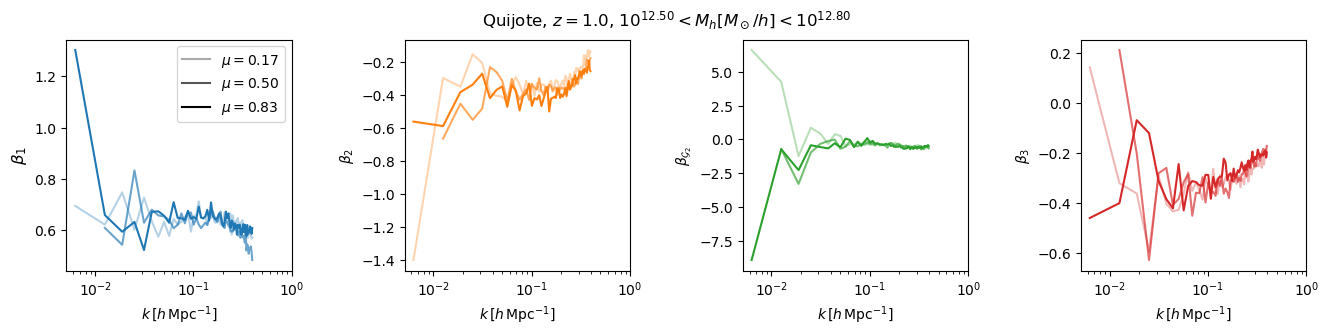

In [44]:
kind_kmax1 = kk<1
Nmu0 = mus.size
# mu = mus

fig, ax = plt.subplots(1,4, sharex=True, figsize=(16,3))

for i in range(Nmu0):
    ax[0].semilogx(kk, beta1[:,i], 'C0', alpha=(i+1)/Nmu0)
    ax[1].semilogx(kk, beta2[:,i], 'C1', alpha=(i+1)/Nmu0)
    ax[2].semilogx(kk, betaG2[:,i], 'C2', alpha=(i+1)/Nmu0)
    ax[3].semilogx(kk, beta3[:,i], 'C3', alpha=(i+1)/Nmu0)
ax[0].set_ylabel('$\\beta_1$', fontsize=12)
ax[1].set_ylabel('$\\beta_2$')
ax[2].set_ylabel('$\\beta_{\\mathcal{G}_2}$')
ax[3].set_ylabel('$\\beta_3$')
plt.subplots_adjust(wspace=0.5, hspace=0)
ax[0].plot([],[], 'k', alpha=((0+1)/Nmu0), label='$\\mu=%.2f$'%mus[0])
ax[0].plot([],[], 'k', alpha=((1+1)/Nmu0), label='$\\mu=%.2f$'%mus[1])
ax[0].plot([],[], 'k', alpha=((2+1)/Nmu0), label='$\\mu=%.2f$'%mus[2])
# ax[0].axhline(b1-1)

for axi in ax.reshape(-1): 
    axi.set_xlim(right=1)
    axi.set_xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$")
#     axi.axvline(kmax_arr[-1], color='gray', ls=':', label="$k_\mathrm{max}=%.1f\,[h\,\mathrm{Mpc}^{-1}]$"%kmax_arr[-1])
ax[0].legend(loc=0)
# fig.suptitle("Quijote, $z=%.1f$"%(zout))
fig.suptitle("Quijote, $z=%.1f$, $10^{%.2f}<M_h[M_\\odot/h]<10^{%.2f}$"%(zout, np.log10(Mh_bins[0]), np.log10(Mh_bins[1])))

# if not os.path.exists('./Figures/rsd_transfer_functions_TNG300-1_z=%.1f_decic_horizontal.pdf'%(zout)):
#     plt.savefig('./Figures/rsd_transfer_functions_TNG300-1_z=%.1f_decic_horizontal.pdf'%(zout), bbox_inches='tight')

In [45]:
def rsd_filter_beta1(k3vec, val):
    absk = (sum(ki**2 for ki in k3vec))**0.5  # absk on the mesh
    # Dont use absk[absk==0]=1 b/c interp does not allow k=1.
    with np.errstate(invalid='ignore',
                     divide='ignore'):
        mu = sum(k3vec[i] * prsd.attrs['los'][i] for i in range(3)) / absk
    return beta1_interkmu(absk, mu) * val

def rsd_filter_beta2(k3vec, val):
    absk = (sum(ki**2 for ki in k3vec))**0.5  # absk on the mesh
    # Dont use absk[absk==0]=1 b/c interp does not allow k=1.
    with np.errstate(invalid='ignore',
                     divide='ignore'):
        mu = sum(k3vec[i] * prsd.attrs['los'][i] for i in range(3)) / absk
    return beta2_interkmu(absk, mu) * val

def rsd_filter_betaG2(k3vec, val):
    absk = (sum(ki**2 for ki in k3vec))**0.5  # absk on the mesh
    # Dont use absk[absk==0]=1 b/c interp does not allow k=1.
    with np.errstate(invalid='ignore',
                     divide='ignore'):
        mu = sum(k3vec[i] * prsd.attrs['los'][i] for i in range(3)) / absk
    return betaG2_interkmu(absk, mu) * val

def rsd_filter_beta3(k3vec, val):
    absk = (sum(ki**2 for ki in k3vec))**0.5  # absk on the mesh
    # Dont use absk[absk==0]=1 b/c interp does not allow k=1.
    with np.errstate(invalid='ignore',
                     divide='ignore'):
        mu = sum(k3vec[i] * prsd.attrs['los'][i] for i in range(3)) / absk
    return beta3_interkmu(absk, mu) * val

beta11 = d1.apply(rsd_filter_beta1, kind='wavenumber')
beta11[np.isnan(beta11)]=0+0j

beta22 = d2.apply(rsd_filter_beta2, kind='wavenumber')
beta22[np.isnan(beta22)]=0+0j

betaG2G2 = dG2.apply(rsd_filter_betaG2, kind='wavenumber')
betaG2G2[np.isnan(betaG2G2)]=0+0j

beta33 = d3.apply(rsd_filter_beta3, kind='wavenumber')
beta33[np.isnan(beta33)]=0+0j

final_field = dz-3./7.*fout*dG2par + beta11 + beta22 + betaG2G2 + beta33
final_field_quad = dz-3./7.*fout*dG2par + beta11 + beta22 + betaG2G2
diff = (catrsd.to_field(mode='complex') - final_field).c2r()
diff_quad = (catrsd.to_field(mode='complex') - final_field_quad).c2r()

perr = FFTPower(diff, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
perr_quad = FFTPower(diff_quad, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pbf = FFTPower(final_field, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)
pbf_quad = FFTPower(final_field_quad, mode='2d', kmin=kmin, poles=[0,2], Nmu=Nmufid)


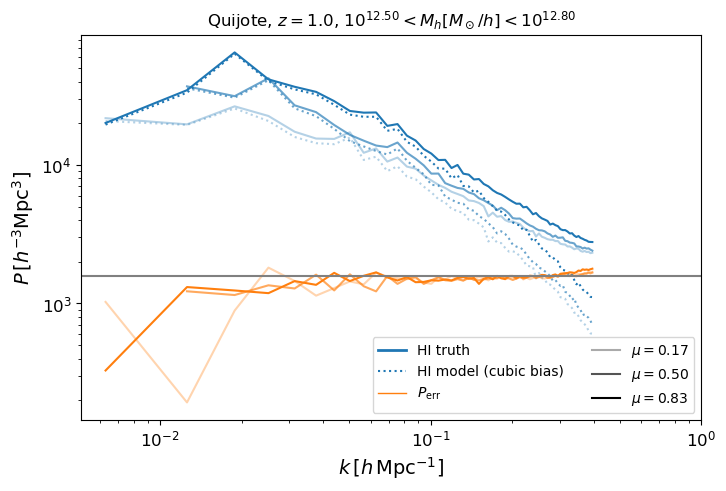

In [46]:
plt.figure(figsize=(8,5))

for i in range(Nmu0):
    plt.loglog(kk, prsd.power['power'][:,Nmu0:].real[:,i], 'C0', alpha=((i+1)/Nmu0))
    plt.loglog(kk, pbf.power['power'][:,Nmu0:].real[:,i], 'C0:', alpha=((i+1)/Nmu0))
    plt.loglog(kk, perr.power['power'][:,Nmu0:].real[:,i], 'C1', alpha=((i+1)/Nmu0))

plt.plot([],[], 'C0', lw=2, label='HI truth')
plt.plot([],[], 'C0:', label='HI model (cubic bias)')
plt.plot([],[], 'C1', lw=1, label='$P_\\mathrm{err}$')

plt.plot([],[], 'k', alpha=((0+1)/Nmu0), label='$\\mu=%.2f$'%mus[0])
plt.plot([],[], 'k', alpha=((1+1)/Nmu0), label='$\\mu=%.2f$'%mus[1])
plt.plot([],[], 'k', alpha=((2+1)/Nmu0), label='$\\mu=%.2f$'%mus[2])

# plt.ylim(1)
plt.xlim(right=1)
plt.title("Quijote, $z=%.1f$, $10^{%.2f}<M_h[M_\\odot/h]<10^{%.2f}$"%(zout, np.log10(Mh_bins[0]), np.log10(Mh_bins[1])))
plt.xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=14)
plt.ylabel("$P\,[h^{-3}\mathrm{Mpc}^3]$", fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(loc=0, ncol=2, frameon=True)
plt.axhline(1/nbar, c='gray')
# zPerr = np.loadtxt("../New_results/Poly_params/z_Perr.txt", unpack=True)
# plt.axhline(zPerr[1][zout==zPerr[0]], ls='--', c='gray')
# if not os.path.exists("./Figures/rs d_Pks_TNG300_zout_%.1f_L_%.0f_nbar_%.f_Nmesh_%d_axis_%i_decic_kmax1_simple_cubic.pdf"%(zout, BoxSize, nbar, Nmesh, axis)):
#     plt.savefig("./Figures/rsd_Pks_TNG300_zout_%.1f_L_%.0f_nbar_%.f_Nmesh_%d_axis_%i_decic_kmax1_simple_cubic.pdf"%(zout, BoxSize, nbar, Nmesh, axis), bbox_inches='tight')

In [47]:
perr_quad.power['power'][:,Nmu0:].real.shape

(63, 3)

0 3 0.3333333333333333
1 3 0.6666666666666666
2 3 1.0


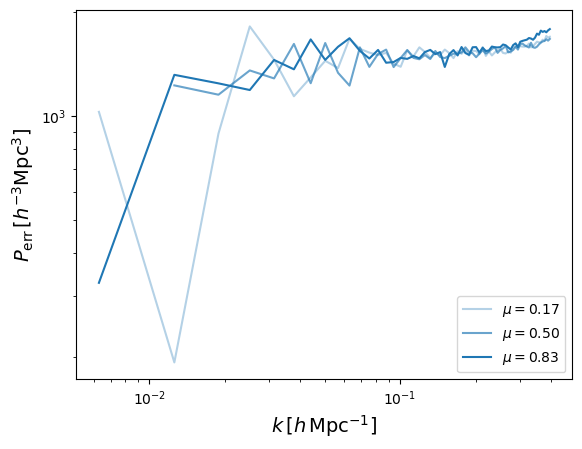

In [53]:
for i in range(Nmu0):
    print (i, Nmu0, (i+1)/Nmu0)
    plt.loglog(kk, perr.power['power'][:,Nmu0:].real[:,i], 'C0', alpha=(i+1)/Nmu0)
plt.xlabel("$k\,[h\,\mathrm{Mpc}^{-1}]$", fontsize=14)
plt.ylabel("$P_\\mathrm{err}\,[h^{-3}\mathrm{Mpc}^3]$", fontsize=14)
plt.plot([],[], 'C0', alpha=((0+1)/Nmu0), label='$\\mu=%.2f$'%mus[0])
plt.plot([],[], 'C0', alpha=((1+1)/Nmu0), label='$\\mu=%.2f$'%mus[1])
plt.plot([],[], 'C0', alpha=((2+1)/Nmu0), label='$\\mu=%.2f$'%mus[2])
plt.legend(loc=0)

Text(0, 0.5, '$z\\,[h^{-1}\\,\\mathrm{Mpc}]$')

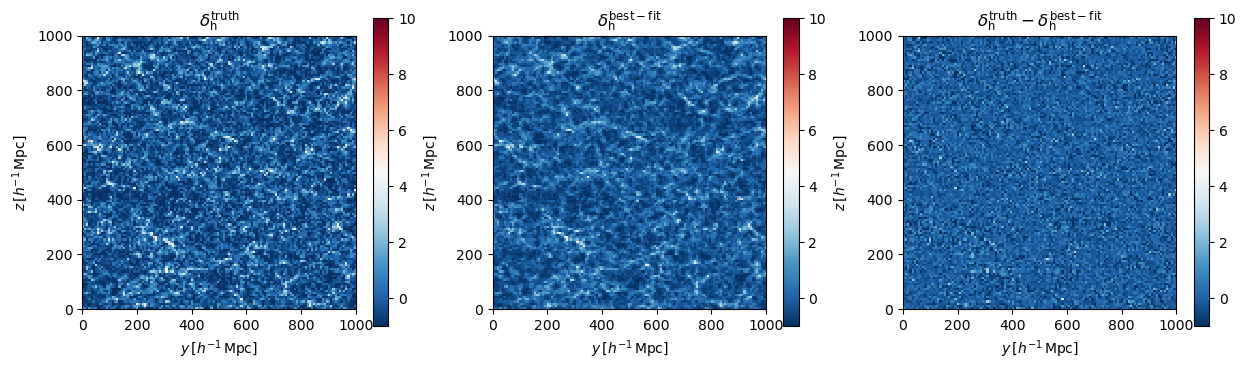

In [54]:
titles = np.array(['HI truth', 'HI bestfit', 'diff'])
imshow_kw = dict(interpolation='none', cmap='RdBu_r', vmin=-1, vmax=10, extent=(0,BoxSize,0,BoxSize), origin='lower')
plt.figure(figsize=(15,4))
plt.subplot(131)
cax = plt.imshow(catrsd.apply(Gaussian(1)).paint()[:int(20*Nmesh/256),:,:].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{h}^\\mathrm{truth}$')
plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.subplot(132)
cax = plt.imshow(ArrayMesh(final_field, BoxSize).apply(Gaussian(1)).paint()[:int(20*Nmesh/256),:,:].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{h}^\\mathrm{best-fit}$')
plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.subplot(133)
cax = plt.imshow(ArrayMesh(diff, BoxSize).apply(Gaussian(1)).paint()[:int(20*Nmesh/256),:,:].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{h}^\\mathrm{truth} - \\delta_\\mathrm{h}^\\mathrm{best-fit}$')
plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")
# plt.savefig(output_folder + 'rsd_truth_bestfitcubic_diff_z=%.1f_yz_Nmesh_%i.pdf'%(zout, Nmesh), bbox_inches='tight')
# plt.close()

# path_to_save = output_folder + "RSD_TNG300-1_zout_%.1f_grid_Nmesh_%i"%(zout, Nmesh)
# results = kk, mus, perr.power['power'][:,Nmu0:].real, prsd.power['power'][:,Nmu0:].real, pbf.power['power'][:,Nmu0:].real, \
#             rhi_bf, beta1, beta2, betaG2, beta3
# if not os.path.exists(path_to_save):
#     np.save(path_to_save, results)

# final_field = final_field.c2r()    
# np.save(output_folder+"rsd_best_fit_field_zout_%.1f_grid_Nmesh_%i"%(zout, Nmesh), final_field.value)
